## Simulation-Based Inference SIR Model: Computing pdf from cdf
Created: May 23, 2022 Prosper and Prosper<br>
Updated: Apr 05, 2023 HBP<br>
Updated: Oct 30, 2023 HBP

### Introduction 

The purpose of this notebook is to approximate $\mathbb{P}(\lambda \le \lambda_0 | \theta) = \mathbb{E}(Z | \theta)$ in two different ways: 1) using a 2D histogram and 2) a neural network, where for a given hypothesis $H_0: \theta = \theta_0$ versus $H_1: \theta \ne \theta_0$, $\lambda_0$ is the observed value of the test statistic $\lambda$ (see SIR_generate_data.ipynb for details.)

Our test statistic $\lambda$  is large for parameters $\theta$ *disfavored* by the data, whereas in the algorithm of Ref.[1], a modified version of which we use, $\lambda$ is small for disfavored parameters. Therefore, we're approximating the cumulative distribution function (cdf) rather than the p-value. 

The stochastic forward simulator $F_\theta$ is the CTMC simulator in notebook SIR_generate_data.ipynb, which simulates the ensemble of synthetic epidemics.


### Approximating $\mathbb{P}(\lambda \le \lambda_0 | \theta) = \mathbb{E}(Z | \theta)$ by histogramming

The quantity $\mathbb{E}(Z | \theta)$ can be approximated using the following algorithm, which therefore provides a way to check the quality of the deep neural network model.

$\theta = \alpha, \beta$

  1. Create histogram $h_w \gets \text{histogram}(\alpha, \beta, \text{weight}=Z)$
  1. Create histogram $h_u \gets \text{histogram}(\alpha, \beta, \text{weight}=1)$
  1. Approximate $\mathbb{P}(\lambda \le \lambda_0 | \alpha, \beta)$ by $h_w \, / \, h_u$

### References
  1. Ann Lee *et al.*, https://arxiv.org/abs/2107.03920

In [1]:
import os, sys

sys.path.append('../')

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

# standard scientific python module
import scipy as sp
import scipy.stats as st
import scipy.optimize as op

# module to save results
#import joblib as jb

# pytorch
import torch
import torch.nn as nn

from tqdm import tqdm

# split data into a training set and a test set
from sklearn.model_selection import train_test_split

# to reload modules
import importlib

import SIR_dnn_util as ut
from SIR_gen_util import generate, Fsolve, test_statistic, SIRdata

%matplotlib inline

device: cpu


In [2]:
# update fonts
FONTSIZE = 12
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
seed = 42
rnd  = np.random.RandomState(seed)

### Load data

__Note__: The $\alpha$ and $\beta$ parameters have been scaled so that they are of $\cal{O}(1)$. Therefore, no further transformation is needed.

In [3]:
print('SIRdata')
data = SIRdata
data.alpha_min,  data.alpha_max = 0.10, 0.90
data.beta_min,   data.beta_max  = 0.25, 0.65
print(data)
print()

datafile = f'../data/SIR_traindata_110k.csv.gz'

print('loading %s' % datafile)
df = pd.read_csv(datafile)
print('number of rows:', len(df))

df[:5]

SIRdata
 D           : [  3  25  75 227 296 258 236 192 126  71  28  11   7]
 I0          : 3
 O           : [  3  25  75 227 296 258 236 192 126  71  28  11   7]
 R0          : 0
 S0          : 763
 T           : [ 0  2  3  4  5  6  7  8  9 10 11 12 13]
 alpha0      : 0.465
 alpha_bins  : 16
 alpha_max   : 0.9
 alpha_min   : 0.1
 alpha_scale : 1.0
 beta0       : 0.00237
 beta_bins   : 16
 beta_max    : 0.65
 beta_min    : 0.25
 beta_scale  : 0.005
 model       : SIR
 scale       : 50
 tmax        : 14.0
 tmin        : 0.0


loading ../data/SIR_traindata_110k.csv.gz
number of rows: 110000


,alpha,beta,li,lo,l0,Zo,Z0,i,I
0,0.556824,0.432547,0.015810,0.629072,0.068463,1.0,1.0,"[3, 33, 61, 149, 208, 217, 181, 125, 85, 61, 3...","[3.0, 25.41, 66.24, 140.76, 212.17, 226.2, 190..."
1,0.917183,0.617733,0.037291,0.150635,0.323215,1.0,1.0,"[3, 19, 101, 180, 180, 125, 72, 38, 21, 7, 9, ...","[3.0, 46.43, 126.68, 188.65, 160.33, 101.22, 5..."
2,0.222595,0.684092,0.022214,0.545157,0.178384,1.0,1.0,"[3, 271, 514, 499, 413, 325, 265, 201, 155, 12...","[3.0, 232.07, 521.39, 511.27, 423.76, 341.88, ..."
3,0.513685,0.231400,0.098132,0.418606,0.630670,1.0,1.0,"[3, 6, 11, 23, 39, 63, 81, 97, 95, 98, 75, 59,...","[3.0, 6.22, 8.89, 12.59, 17.59, 24.14, 32.47, ..."
4,0.533168,0.343659,0.047897,0.071392,0.198700,1.0,1.0,"[3, 8, 19, 30, 52, 97, 150, 151, 124, 125, 106...","[3.0, 13.87, 28.69, 55.72, 97.06, 143.04, 172...."


### Load coverage data

In [12]:
df = pd.read_csv('../data/SIR_coverage_data.csv.gz')

alpha = df['alpha'].to_numpy()
beta  = df['beta'].to_numpy()
li    = np.array([eval(x) for x in df.l])
N, K  = li.shape

print('number of parameter points, sample size: %d, %d' % (N, K))
df[:5]

number of parameter points, sample size: 249, 4000


,alpha,beta,l
0,0.515374,0.490942,"[0.026923867237551094, 0.080357968198306, 0.01..."
1,0.447310,0.566963,"[0.03919273462108729, 0.020078406626004477, 0...."
2,0.636584,0.526598,"[0.06104277253195194, 0.039168254312841745, 0...."
3,0.315896,0.366369,"[0.05353438554726757, 0.020809563281201884, 0...."
4,0.499624,0.354600,"[0.08851203191960628, 0.02607256422172975, 0.0..."


In [4]:
import models.SIR_dnn_cdf_100k as NN
importlib.reload(NN)
name     = NN.name
model    = NN.model
features = NN.features
target   = NN.target

modelfile  = '../models/%s.dict' % NN.name
print(name)
print(model)
print('number of parameters: %d' % ut.number_of_parameters(model))

modeldict = torch.load(modelfile)
NN.model.load_state_dict(modeldict);

SIR_dnn_cdf_100k
Sequential(
  (0): Linear(in_features=3, out_features=20, bias=True)
  (1): SiLU()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): SiLU()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): SiLU()
  (6): Linear(in_features=20, out_features=20, bias=True)
  (7): SiLU()
  (8): Linear(in_features=20, out_features=20, bias=True)
  (9): SiLU()
  (10): Linear(in_features=20, out_features=20, bias=True)
  (11): SiLU()
  (12): Linear(in_features=20, out_features=1, bias=True)
  (13): Sigmoid()
)
number of parameters: 2201


### Trained Model

This class places a convenient wrapper around the cdf model, $F(\lambda|\alpha, \beta)$, and computes the pdf, $f(\lambda|\alpha, \beta)$, using
\begin{align}
    f(\lambda|\alpha, \beta) & = \frac{\partial F}{\partial \lambda} .
\end{align}

In [21]:
class TrainedModel:
    
    def __init__(self, model):
        self.model = model # cache CDF model
    
    def __cdf(self, alpha, beta, lo): 
        a = np.array([alpha, beta, lo]).T        
        X = torch.Tensor(a)
        X.requires_grad_(True)
        self.model.eval() 
        return self.model(X), X 
        
    def cdf(self, alpha, beta, lo):
        '''
        Inputs alpha, beta, lo should be numpy arrays of the same shape.
        '''
        F, _ = self.__cdf(alpha, beta, lo)
        Y = F.view(-1).detach().numpy()
        if len(Y) == 1:
            Y = Y[0]
        return Y

    def pdf(self, alpha, beta, lo):
        F, X = self.__cdf(alpha, beta, lo)

        dFdX = torch.autograd.grad(outputs=F, inputs=X, 
                                   grad_outputs=torch.ones_like(F),
                                   create_graph=True)[0]
        
        Y = dFdX.detach().numpy()
        if len(Y) == 1:
            _, _, Y = Y[0]
        return Y.T[-1]  

In [22]:
tmodel = TrainedModel(model)

In [29]:
def plot_pdfs(alpha, beta, l, dnn, N=12, 
              xbins=20, xmin=0, xmax=0.20,
              filename='../images/fig_SIR_pdf.pdf', fgsize=(8, 8), ftsize=10):

    # create an empty figure
    fig = plt.figure(figsize=fgsize)
    fig.tight_layout()
    
    # adjust padding
    plt.subplots_adjust(hspace=0.25)
    plt.subplots_adjust(wspace=0.40)

    # work out number of rows
    ncols = 4
    nrows = N // ncols
    nplots= nrows * ncols

    # loop over coefficients

    for i, (a, b, t) in enumerate(zip(alpha[:nplots], beta[:nplots], l[:nplots])):

        ax = fig.add_subplot(nrows, ncols, i+1)

        ax.set_xlim(xmin, xmax)
        
        if i > (nrows-1) * ncols-1:
            ax.set_xlabel(r'$\lambda$', fontsize=ftsize)

        if i % ncols == 0:
            ax.set_ylabel(r'$f(\lambda|\theta_0)$', fontsize=ftsize)

        ax.hist(t, bins=xbins, range=(xmin, xmax), 
                color='green', density=True, alpha=0.4)

        x = np.linspace(xmin, xmax, 5*xbins+1)
        a = a * np.ones_like(x)
        b = b * np.ones_like(x)
        y = dnn.pdf(a, b, x)
        ax.plot(x, y, color='blue')

        # annotate plot
        ymin = 0
        ymax = 1.2 * y.max()
        xpos = xmin + 0.40 * (xmax-xmin)
        ypos = ymin + 0.80 * (ymax-ymin)
        ystep= (ymax-ymin)/6
        ypos -= ystep
        ax.text(xpos, ypos, r'$\alpha, \beta$'); ypos -= ystep
        ax.text(xpos, ypos, '%5.2f,%5.2f' % (alpha[i], beta[i]))
            
    print(filename)
    plt.savefig(filename)

../images/fig_SIR_pdf.pdf


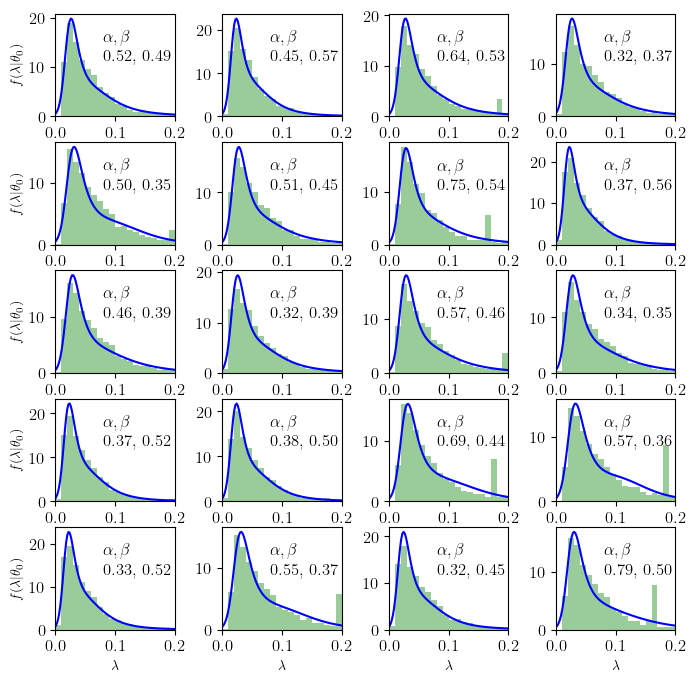

In [30]:
plot_pdfs(alpha, beta, li, tmodel, N=20)